#### Analysis of stem cells niches in Xenium add-on panel healthy gut data with `NicheCompass`
- **Developed by:** Anna Maguza
- **Place:** Wuerzburg Institute for System Immunology
- **Date:** 25th March 2024

#### Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random
import warnings
from datetime import datetime
#import gdown

import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import seaborn as sns
import squidpy as sq
from matplotlib import gridspec
from sklearn.preprocessing import MinMaxScaler
import numpy as np

from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                compute_communication_gp_network,
                                visualize_communication_gp_network,
                                create_new_color_dict,
                                extract_gp_dict_from_mebocost_es_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps,
                                generate_enriched_gp_info_plots)

In [3]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

#### Define Parameters

In [4]:
### Dataset ###
dataset = "human_intestine"
species = "human"
spatial_key = "spatial"
n_neighbors = 4

### Model ###
# AnnData Keys
counts_key = "counts"
adj_key = "spatial_connectivities"
gp_names_key = "nichecompass_gp_names"
active_gp_names_key = "nichecompass_active_gp_names"
gp_targets_mask_key = "nichecompass_gp_targets"
gp_targets_categories_mask_key = "nichecompass_gp_targets_categories"
gp_sources_mask_key = "nichecompass_gp_sources"
gp_sources_categories_mask_key = "nichecompass_gp_sources_categories"
latent_key = "nichecompass_latent"

# Architecture
conv_layer_encoder = "gcnconv" # change to "gatv2conv" if enough compute and memory
active_gp_thresh_ratio = 0.01

# Trainer
n_epochs = 400
n_epochs_all_gps = 25
lr = 0.001
lambda_edge_recon = 500000.
lambda_gene_expr_recon = 300.
lambda_l1_masked = 0. # increase if gene selection desired
lambda_l1_addon = 100.
edge_batch_size = 1024 # increase if more memory available
n_sampled_neighbors = 4
use_cuda_if_available = True

### Analysis ###
cell_type_key = "CellType2"
latent_leiden_resolution = 0.4
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"
sample_key = "Sample_id"
spot_size = 0.2
differential_gp_test_results_key = "nichecompass_differential_gp_test_results"

#### Run Notebook Setup

In [5]:
warnings.filterwarnings("ignore")

In [ ]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

In [6]:
#current_timestamp = '05042024_120038'

#### Configure Paths

In [9]:
!pwd

/home/amaguza


In [7]:
# Define paths
ga_data_folder_path = "/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/10X_Xenium_data/NicheCompass/Xenium_add_on/NicheCompass/gene_annotations"
gp_data_folder_path = "/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/10X_Xenium_data/NicheCompass/Xenium_add_on/NicheCompass/gene_programs"
so_data_folder_path = "/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/10X_Xenium_data/NicheCompass/Xenium_add_on/NicheCompass/spatial_omics"
omnipath_lr_network_file_path = f"{gp_data_folder_path}/omnipath_lr_network.csv"
collectri_tf_network_file_path = f"{gp_data_folder_path}/collectri_tf_network_{species}.csv"
nichenet_lr_network_file_path = f"{gp_data_folder_path}/nichenet_lr_network_v2_{species}.csv"
nichenet_ligand_target_matrix_file_path = f"{gp_data_folder_path}/nichenet_ligand_target_matrix_v2_{species}.csv"
mebocost_enzyme_sensor_interactions_folder_path = f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps"
gene_orthologs_mapping_file_path = f"{ga_data_folder_path}/human_mouse_gene_orthologs.csv"
artifacts_folder_path = f"/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/10X_Xenium_data/NicheCompass/Xenium_add_on/NicheCompass/artifacts"
model_folder_path = f"{artifacts_folder_path}/single_sample/{current_timestamp}/model"
figure_folder_path = f"{artifacts_folder_path}/single_sample/{current_timestamp}/figures"

#### Create Directories

In [13]:
import os
os.makedirs(model_folder_path, exist_ok=True)
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(so_data_folder_path, exist_ok=True)

#### Upload the anndata file

In [10]:
adata = sc.read_h5ad('/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/10X_Xenium_data/Xenium_add_on_celltypes_and_stem_cells_types_without_image.h5ad')

In [11]:
X_is_raw(adata)

True

#### Prepare Model Training

+ Create Prior Knowledge Gene Program (GP) Mask

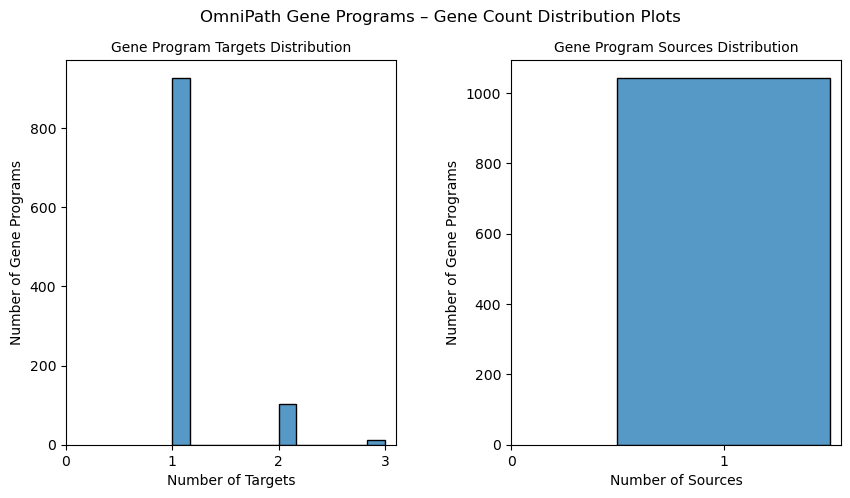

In [12]:
# Retrieve OmniPath GPs (source: ligand genes; target: receptor genes)
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    species=species,
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=True,
    lr_network_file_path=omnipath_lr_network_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=True,
    gp_gene_count_distributions_save_path=f"{figure_folder_path}" \
                                           "/omnipath_gp_gene_count_distributions.svg")

In [13]:
# Display example OmniPath GP
omnipath_gp_names = list(omnipath_gp_dict.keys())
random.shuffle(omnipath_gp_names)
omnipath_gp_name = omnipath_gp_names[0]
print(f"{omnipath_gp_name}: {omnipath_gp_dict[omnipath_gp_name]}")

BMP3_ligand_receptor_GP: {'sources': ['BMP3'], 'targets': ['ACVR1'], 'sources_categories': ['ligand'], 'targets_categories': ['receptor']}


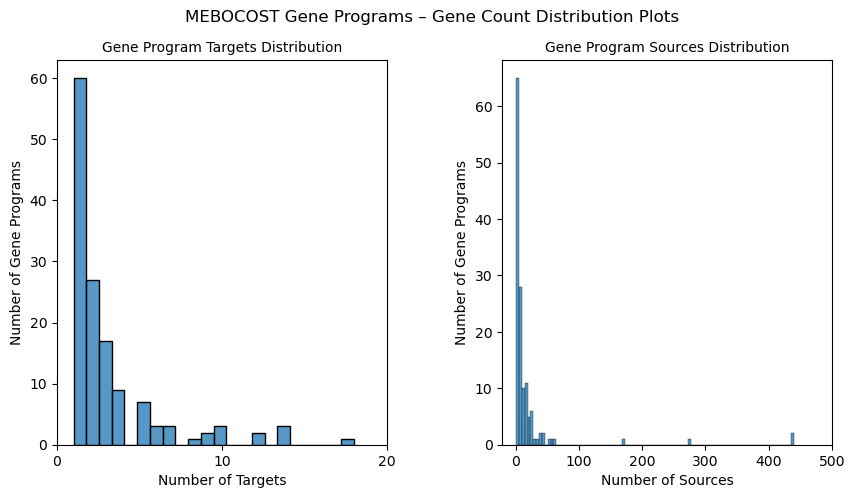

In [14]:
# Retrieve MEBOCOST GPs (source: enzyme genes; target: sensor genes)
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=mebocost_enzyme_sensor_interactions_folder_path,
    species=species,
    plot_gp_gene_count_distributions=True)

In [15]:
# Display example MEBOCOST GP
mebocost_gp_names = list(mebocost_gp_dict.keys())
random.shuffle(mebocost_gp_names)
mebocost_gp_name = mebocost_gp_names[0]
print(f"{mebocost_gp_name}: {mebocost_gp_dict[mebocost_gp_name]}")

Creatine_metabolite_enzyme_sensor_GP: {'sources': ['CKB', 'CKM', 'CKMT1A', 'CKMT2', 'GAMT'], 'sources_categories': ['enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme'], 'targets': ['SLC16A12', 'SLC22A5'], 'targets_categories': ['sensor', 'sensor']}


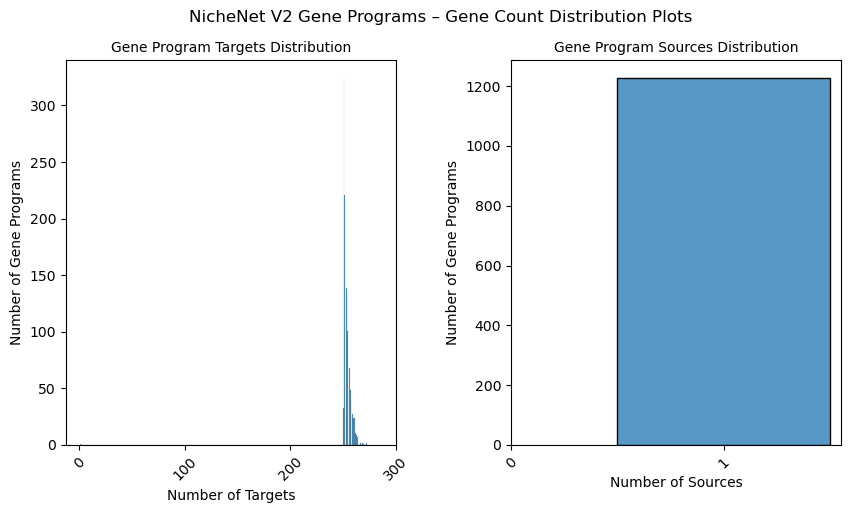

In [16]:
# Retrieve NicheNet GPs (source: ligand genes; target: receptor genes, target genes)
nichenet_gp_dict = extract_gp_dict_from_nichenet_lrt_interactions(
    species=species,
    version="v2",
    keep_target_genes_ratio=1.,
    max_n_target_genes_per_gp=250,
    load_from_disk=False,
    save_to_disk=True,
    lr_network_file_path=nichenet_lr_network_file_path,
    ligand_target_matrix_file_path=nichenet_ligand_target_matrix_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=True)

In [17]:
# Display example NicheNet GP
nichenet_gp_names = list(nichenet_gp_dict.keys())
random.shuffle(nichenet_gp_names)
nichenet_gp_name = nichenet_gp_names[0]
print(f"{nichenet_gp_name}: {nichenet_gp_dict[nichenet_gp_name]}")

IL26_ligand_receptor_target_gene_GP: {'sources': ['IL26'], 'targets': ['IL20RA', 'IL10RB', 'IL20RB', 'ABCC9', 'ADPRH', 'AHNAK', 'AKAP7', 'ALDH1A3', 'ALDH1L2', 'ALKBH6', 'AMIGO2', 'ANG', 'ANXA3', 'AP1S1', 'APOB', 'APP', 'ARHGAP36', 'ARHGAP42', 'ARID4A', 'ARRDC4', 'ASPHD2', 'ATP11B', 'BAX', 'BBS2', 'BCAT1', 'BCCIP', 'BCHE', 'BCL6', 'BID', 'C12orf54', 'C17orf75', 'C21orf91', 'C2CD4A', 'C4orf45', 'CAB39L', 'CAPNS2', 'CAVIN2', 'CBS', 'CCDC113', 'CCDC59', 'CCL20', 'CD36', 'CDKN1A', 'CEACAM5', 'CEACAM6', 'CENPT', 'CES5A', 'CHAC1', 'CHI3L1', 'CKS2', 'CMIP', 'COPA', 'CREB3L2', 'CRHBP', 'CRLS1', 'CRNN', 'CRYAB', 'CTHRC1', 'CTNNB1', 'CXCL1', 'DAD1', 'DDIT4', 'DDX17', 'DHX35', 'DLX2', 'DNAI3', 'DNAJC3', 'DPYD', 'DUSP1', 'DUSP2', 'ECM1', 'EGLN3', 'ENPP6', 'EPB41L3', 'EPS8', 'ERBB2', 'ESYT2', 'EXOC4', 'EXOSC8', 'FABP7', 'FAM83A', 'FASTKD1', 'FBP1', 'FCF1', 'FECH', 'FKBP5', 'FMO5', 'FN1', 'FOS', 'FOXQ1', 'FRAT1', 'FSIP1', 'FTH1P5', 'G0S2', 'GALNT6', 'GBP2', 'GFOD1', 'GHR', 'GNL3', 'GPNMB', 'H1-2', 'H

In [18]:
# Add GPs into one combined dictionary for model training
combined_gp_dict = dict(omnipath_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)
combined_gp_dict.update(nichenet_gp_dict)

In [19]:
# Filter and combine GPs to avoid overlaps
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode="subset",
    combine_overlap_gps=True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9)

print("Number of gene programs before filtering and combining: "
      f"{len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: "
      f"{len(combined_new_gp_dict)}.")

Number of gene programs before filtering and combining: 2406.
Number of gene programs after filtering and combining: 1987.


#### Compute Spatial Neighbor Graph for adata

In [20]:
adata.obs

,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area,...,log1p_n_genes_by_counts,log1p_total_counts,pct_counts_in_top_10_genes,pct_counts_in_top_20_genes,pct_counts_in_top_50_genes,pct_counts_in_top_150_genes,n_counts,Cell_Type,Stem_cells,CellType2
cell_id,,,,,,,,,,,,,,,,,,,,,
aaaagkoa-1,830.147217,836.563416,284,0,0,0,0,284.0,653.365805,23.120001,...,4.094345,5.652489,58.450704,76.056338,96.830986,100.0,284.0,Mesenchymal,Unknown,Mesenchymal
aaablbol-1,735.468018,854.389282,116,0,0,0,0,116.0,651.243461,12.643750,...,3.688879,4.762174,65.517241,82.758621,100.000000,100.0,116.0,Mesenchymal,Unknown,Mesenchymal
aaabogma-1,847.423462,846.633240,170,0,0,0,0,170.0,674.544087,18.152813,...,3.496508,5.141664,72.941176,92.941176,100.000000,100.0,170.0,Mesenchymal,Unknown,Mesenchymal
aaabpdim-1,1543.696045,4223.798340,61,0,0,0,0,61.0,172.406569,11.379375,...,3.258097,4.127134,75.409836,91.803279,100.000000,100.0,61.0,Mesenchymal,Unknown,Mesenchymal
aaabpfoj-1,1551.099121,4220.062988,105,0,0,0,0,105.0,283.490948,56.806565,...,3.526361,4.663439,73.333333,87.619048,100.000000,100.0,105.0,Mesenchymal,Unknown,Mesenchymal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
oikabfkp-1,8284.036133,3061.574951,219,0,0,0,0,219.0,70.308284,38.563439,...,3.912023,5.393628,56.164384,79.908676,100.000000,100.0,219.0,Epithelial,Unknown,Epithelial
oikalpjm-1,8267.514648,3067.372314,173,0,0,0,0,173.0,45.743283,11.334219,...,3.931826,5.159055,54.913295,75.722543,100.000000,100.0,173.0,Epithelial,Unknown,Epithelial
oikamhom-1,8260.333984,3068.529053,369,0,0,0,0,369.0,104.040004,46.691564,...,4.204693,5.913503,49.864499,73.170732,95.663957,100.0,369.0,Epithelial,Unknown,Epithelial


In [21]:
adata.obs['Sample_id'] = 'Xenium_V1_hColon_Non_diseased_Add_on'

In [22]:
# Compute spatial neighborhood
sq.gr.spatial_neighbors(adata,
                        coord_type="generic",
                        spatial_key=spatial_key,
                        n_neighs=n_neighbors)

# Make adjacency matrix symmetric
adata.obsp[adj_key] = (
    adata.obsp[adj_key].maximum(
        adata.obsp[adj_key].T))

+ Add GP Mask to Data

In [23]:
# Add the GP dictionary as binary masks to the adata
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_new_gp_dict,
    adata=adata,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_targets_categories_mask_key=gp_targets_categories_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_sources_categories_mask_key=gp_sources_categories_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=2,
    min_source_genes_per_gp=1,
    min_target_genes_per_gp=1,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None)

+ Explore Data

In [24]:
adata.obs

,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area,...,log1p_total_counts,pct_counts_in_top_10_genes,pct_counts_in_top_20_genes,pct_counts_in_top_50_genes,pct_counts_in_top_150_genes,n_counts,Cell_Type,Stem_cells,CellType2,Sample_id
cell_id,,,,,,,,,,,,,,,,,,,,,
aaaagkoa-1,830.147217,836.563416,284,0,0,0,0,284.0,653.365805,23.120001,...,5.652489,58.450704,76.056338,96.830986,100.0,284.0,Mesenchymal,Unknown,Mesenchymal,Xenium_V1_hColon_Non_diseased_Add_on
aaablbol-1,735.468018,854.389282,116,0,0,0,0,116.0,651.243461,12.643750,...,4.762174,65.517241,82.758621,100.000000,100.0,116.0,Mesenchymal,Unknown,Mesenchymal,Xenium_V1_hColon_Non_diseased_Add_on
aaabogma-1,847.423462,846.633240,170,0,0,0,0,170.0,674.544087,18.152813,...,5.141664,72.941176,92.941176,100.000000,100.0,170.0,Mesenchymal,Unknown,Mesenchymal,Xenium_V1_hColon_Non_diseased_Add_on
aaabpdim-1,1543.696045,4223.798340,61,0,0,0,0,61.0,172.406569,11.379375,...,4.127134,75.409836,91.803279,100.000000,100.0,61.0,Mesenchymal,Unknown,Mesenchymal,Xenium_V1_hColon_Non_diseased_Add_on
aaabpfoj-1,1551.099121,4220.062988,105,0,0,0,0,105.0,283.490948,56.806565,...,4.663439,73.333333,87.619048,100.000000,100.0,105.0,Mesenchymal,Unknown,Mesenchymal,Xenium_V1_hColon_Non_diseased_Add_on
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
oikabfkp-1,8284.036133,3061.574951,219,0,0,0,0,219.0,70.308284,38.563439,...,5.393628,56.164384,79.908676,100.000000,100.0,219.0,Epithelial,Unknown,Epithelial,Xenium_V1_hColon_Non_diseased_Add_on
oikalpjm-1,8267.514648,3067.372314,173,0,0,0,0,173.0,45.743283,11.334219,...,5.159055,54.913295,75.722543,100.000000,100.0,173.0,Epithelial,Unknown,Epithelial,Xenium_V1_hColon_Non_diseased_Add_on
oikamhom-1,8260.333984,3068.529053,369,0,0,0,0,369.0,104.040004,46.691564,...,5.913503,49.864499,73.170732,95.663957,100.0,369.0,Epithelial,Unknown,Epithelial,Xenium_V1_hColon_Non_diseased_Add_on


In [25]:
cell_type_colors = create_new_color_dict(
    adata=adata,
    cat_key=cell_type_key)

In [26]:
adata

AnnData object with n_obs × n_vars = 274240 × 425
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'Cell_Type', 'Stem_cells', 'CellType2', 'Sample_id'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'CellType2_colors', 'Cell_Type_colors', 'spatial_neighbors', 'nichecompass_sources_categories_label_encoder', 'nichecompass_targets_categories_label_encoder', 'nichecompass_source_genes_idx', 'nichecompass_target_genes_idx', 'nichecompass_genes_idx', 'nichecompass_gp_names'
    obsm: 'spatial'

In [27]:
adata.layers['counts'] = adata.X.copy()

In [28]:
print(f"Number of nodes (observations): {adata.layers['counts'].shape[0]}")
print(f"Number of node features (genes): {adata.layers['counts'].shape[1]}")

Number of nodes (observations): 274240
Number of node features (genes): 425


In [ ]:
sc.pl.spatial(adata,
              color=cell_type_key,
              palette=cell_type_colors,
              spot_size=10)        

#### Train Model

+ Initialize, Train & Save Model

In [30]:
# Initialize model
model = NicheCompass(adata,
                     counts_key=counts_key,
                     adj_key=adj_key,
                     gp_names_key=gp_names_key,
                     active_gp_names_key=active_gp_names_key,
                     gp_targets_mask_key=gp_targets_mask_key,
                     gp_targets_categories_mask_key=gp_targets_categories_mask_key,
                     gp_sources_mask_key=gp_sources_mask_key,
                     gp_sources_categories_mask_key=gp_sources_categories_mask_key,
                     latent_key=latent_key,
                     conv_layer_encoder=conv_layer_encoder,
                     active_gp_thresh_ratio=active_gp_thresh_ratio)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.01
LOG VARIATIONAL -> True
ONE HOP GCN NORM RNA NODE LABEL AGGREGATOR
ENCODER -> n_input: 425, n_cat_covariates_embed_input: 0, n_hidden: 207, n_latent: 107, n_addon_latent: 100, n_fc_layers: 1, n_layers: 1, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0, 
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED TARGET RNA DECODER -> n_prior_gp_input: 107, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 425
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 107, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 425


In [31]:
# Train model
model.train(n_epochs=n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_l1_masked=lambda_l1_masked,
            edge_batch_size=edge_batch_size,
            n_sampled_neighbors=n_sampled_neighbors,
            use_cuda_if_available=use_cuda_if_available,
            verbose=False)


--- INITIALIZING TRAINER ---
Number of training nodes: 246816
Number of validation nodes: 27424
Number of training edges: 583816
Number of validation edges: 64868
Edge batch size: 1024
Node batch size: None

--- MODEL TRAINING ---
Epoch 1/400 |--------------------| 0.2% train_global_loss: 376046.3425; train_optim_loss: 376046.3425; val_global_loss: 362314.4990; val_optim_loss: 362314.4990
Epoch 2/400 |--------------------| 0.5% train_global_loss: 355537.0554; train_optim_loss: 355537.0554; val_global_loss: 355641.6392; val_optim_loss: 355641.6392
Epoch 3/400 |--------------------| 0.8% train_global_loss: 350183.9349; train_optim_loss: 350183.9349; val_global_loss: 351424.7075; val_optim_loss: 351424.7075
Epoch 4/400 |--------------------| 1.0% train_global_loss: 346596.9542; train_optim_loss: 346596.9542; val_global_loss: 348241.5137; val_optim_loss: 348241.5137
Epoch 5/400 |--------------------| 1.2% train_global_loss: 344384.5956; train_optim_loss: 344384.5956; val_global_loss: 3468

In [32]:
# Compute latent neighbor graph
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_key)

# Compute UMAP embedding
sc.tl.umap(model.adata,
           neighbors_key=latent_key)

In [33]:
# Save trained model
model.save(dir_path=model_folder_path,
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

#### Analysis

In [8]:
load_timestamp = '05042024_120038'
#load_timestamp = current_timestamp 

figure_folder_path = f"{artifacts_folder_path}/single_sample/{load_timestamp}/figures"
model_folder_path = f"{artifacts_folder_path}/single_sample/{load_timestamp}/model"

os.makedirs(figure_folder_path, exist_ok=True)

In [9]:
# Load trained model
model = NicheCompass.load(dir_path=model_folder_path,
                          adata=None,
                          adata_file_name="adata.h5ad",
                          gp_names_key=gp_names_key)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.01
LOG VARIATIONAL -> True
ONE HOP GCN NORM RNA NODE LABEL AGGREGATOR
ENCODER -> n_input: 425, n_cat_covariates_embed_input: 0, n_hidden: 207, n_latent: 107, n_addon_latent: 100, n_fc_layers: 1, n_layers: 1, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0, 
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED TARGET RNA DECODER -> n_prior_gp_input: 107, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 425
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 107, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 425


In [10]:
samples = model.adata.obs[sample_key].unique().tolist()

In [11]:
model.adata

AnnData object with n_obs × n_vars = 274240 × 425
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'Cell_Type', 'Stem_cells', 'CellType2', 'Sample_id'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'CellType2_colors', 'Cell_Type_colors', 'nichecompass_active_gp_names', 'nichecompass_genes_idx', 'nichecompass_gp_names', 'nichecompass_latent', 'nichecompass_source_genes_idx', 'nichecompass_sources_categories_label_encoder', 'nichecompass_target_genes_idx', 'nichecompass_targets_categories_

#### Visualize NicheCompass Latent GP Space

In [12]:
cell_type_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=cell_type_key)

In [ ]:
# Create plot of cell type annotations in physical and latent space
groups = None
save_fig = True
file_path = f"{figure_folder_path}/" \
            "cell_types_latent_physical_space.svg"

fig = plt.figure(figsize=(12, 14), dpi=300)
title = fig.suptitle(t=f"Cell Types " \
                       "in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[cell_type_key],
           groups=groups,palette=cell_type_colors,
           title=f"Cell Types in Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
                  color=[cell_type_key],
                  groups=groups,
                  palette=cell_type_colors,
                  spot_size=spot_size,
                  title=f"Cell Types in Physical Space \n"
                        f"(Sample: {sample})",
                  legend_loc=None,
                  ax=axs[idx+1],
                  show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

#### 4.2 Identify Niches

In [13]:
# Compute latent Leiden clustering
sc.tl.leiden(adata=model.adata,
             resolution=latent_leiden_resolution,
             key_added=latent_cluster_key,
             neighbors_key=latent_key)

In [14]:
latent_cluster_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=latent_cluster_key)

In [ ]:
# Create plot of latent cluster / niche annotations in physical and latent space
groups = None # set this to a specific cluster for easy visualization, e.g. ["17"]
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            "niches_latent_physical_space.svg"

fig = plt.figure(figsize=(12, 14), dpi = 300)
title = fig.suptitle(t=f"NicheCompass Niches " \
                       "in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[latent_cluster_key],
           groups=groups,
           palette=latent_cluster_colors,
           title=f"Niches in Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
                  color=[latent_cluster_key],
                  groups=groups,
                  palette=latent_cluster_colors,
                  spot_size=spot_size,
                  title=f"Niches in Physical Space \n"
                        f"(Sample: {sample})",
                  legend_loc=None,
                  ax=axs[idx+1],
                  show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

#### 4.3 Characterize Niches

+ 4.3.1 Niche Composition

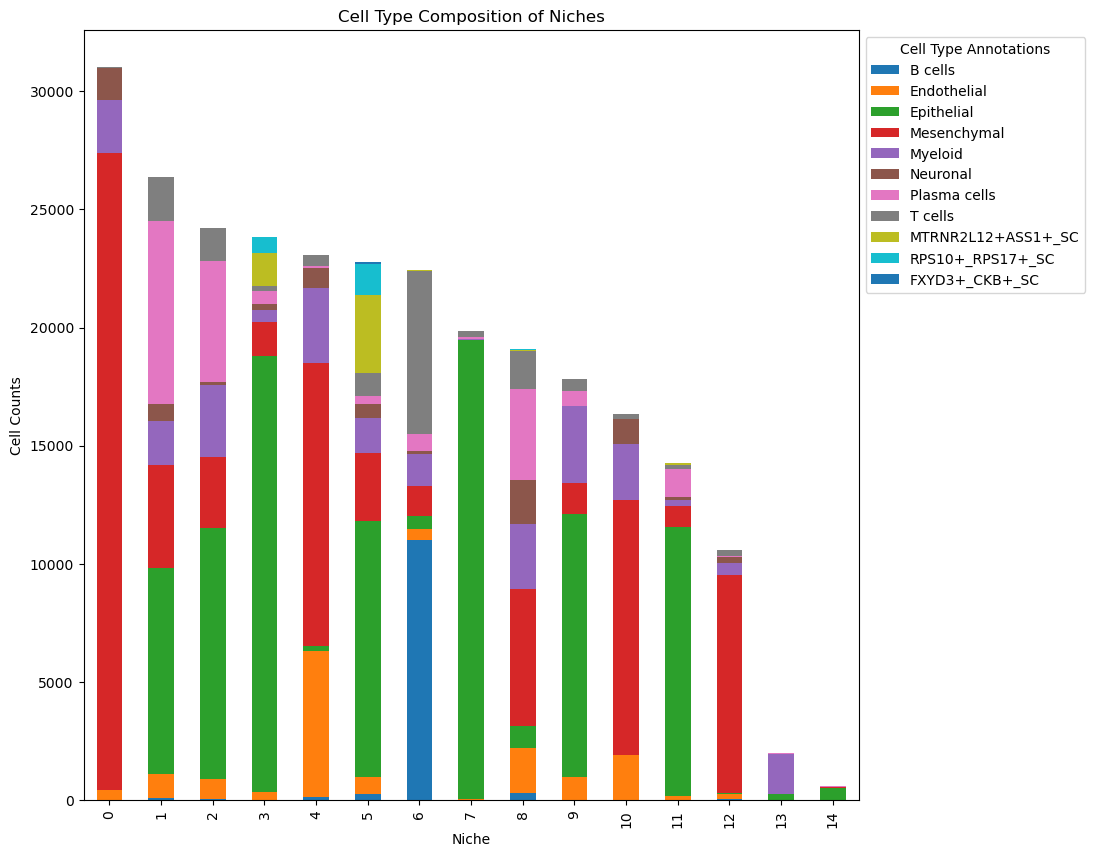

In [15]:
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            f"niche_composition.png"

df_counts = (model.adata.obs.groupby([latent_cluster_key, cell_type_key])
             .size().unstack())
df_counts.plot(kind="bar", stacked=True, figsize=(10, 10))
legend = plt.legend(bbox_to_anchor=(1, 1), loc="upper left", prop={'size': 10})
legend.set_title("Cell Type Annotations", prop={'size': 10})
plt.title("Cell Type Composition of Niches")
plt.xlabel("Niche")
plt.ylabel("Cell Counts")
if save_fig:
    plt.savefig(file_path,
                bbox_extra_artists=(legend,),
                bbox_inches="tight",
                dpi=300)  

In [16]:
df_counts.head(22)

CellType2,B cells,Endothelial,Epithelial,Mesenchymal,Myeloid,Neuronal,Plasma cells,T cells,MTRNR2L12+ASS1+_SC,RPS10+_RPS17+_SC,FXYD3+_CKB+_SC
latent_leiden_0.4,,,,,,,,,,,
0,1,434,0,26948,2233,1350,0,78,0,0,0
1,65,1017,8754,4344,1879,721,7745,1836,0,0,0
2,23,883,10623,2986,3050,127,5127,1386,0,0,0
3,18,326,18447,1444,493,287,519,222,1398,662,25
4,139,6188,172,11998,3193,851,77,447,0,0,0
5,238,739,10826,2885,1484,590,359,936,3304,1311,83
6,10985,491,529,1302,1345,125,696,6910,36,4,2
7,0,39,19426,3,38,1,109,239,0,0,0
8,282,1925,906,5809,2748,1895,3838,1594,47,28,2


In [45]:
df_counts.to_csv(f"{figure_folder_path}/niche_composition.csv")

+ 4.3.2 Differential GPs

In [15]:
# Check number of active GPs
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

Number of total gene programs: 207.
Number of active gene programs: 207.


In [16]:
# Display example active GPs
gp_summary_df = model.get_gp_summary()
gp_summary_df[gp_summary_df["gp_active"] == True].head()

,gp_name,all_gp_idx,gp_active,active_gp_idx,n_source_genes,n_non_zero_source_genes,n_target_genes,n_non_zero_target_genes,gp_source_genes,gp_target_genes,gp_source_genes_weights,gp_target_genes_weights,gp_source_genes_importances,gp_target_genes_importances
0,CXCL10_ligand_receptor_GP,0,True,0,1,1,1,1,[CXCL10],[CXCR1],[0.1133],[0.0088],[0.9278],[0.0722]
1,CCL13_ligand_receptor_GP,1,True,1,1,1,1,1,[CCL13],[CXCR2],[0.4367],[0.0456],[0.9054],[0.0946]
2,CD177_ligand_receptor_GP,2,True,2,1,1,1,1,[CD177],[PECAM1],[2.2735],[-0.0124],[0.9946],[0.0054]
3,gamma-Aminobutyric acid_metabolite_enzyme_sens...,3,True,3,1,1,1,1,[ALDH1B1],[SLC6A8],[2.789],[-1.0885],[0.7193],[0.2807]
4,Norepinephrine_metabolite_enzyme_sensor_GP,4,True,4,1,1,1,1,[MAOB],[ADRA2A],[0.2239],[0.0947],[0.7028],[0.2972]


In [17]:
# Set parameters for differential gp testing
selected_cats = ["5"]
comparison_cats = "rest"
title = f"NicheCompass Strongly Enriched Niche GPs"
log_bayes_factor_thresh = 2.3
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}" \
             "_niches_enriched_gps_heatmap.svg"

In [18]:
# Run differential gp testing
enriched_gps = model.run_differential_gp_tests(
    cat_key=latent_cluster_key,
    selected_cats=selected_cats,
    comparison_cats=comparison_cats,
    log_bayes_factor_thresh=log_bayes_factor_thresh)

In [21]:
# Results are stored in a df in the adata object
model.adata.uns[differential_gp_test_results_key]

,category,gene_program,p_h0,p_h1,log_bayes_factor
0,5,GZMB_ligand_receptor_target_gene_GP,0.003670,0.996330,-5.603857
1,5,RBP4_ligand_receptor_target_gene_GP,0.991449,0.008551,4.753156
2,5,SLC6A8_ligand_receptor_target_gene_GP,0.978892,0.021108,3.836770
3,5,Add-on_45_GP,0.021888,0.978112,-3.799667
4,5,Add-on_11_GP,0.973724,0.026276,3.612483
5,5,CCL13_ligand_receptor_target_gene_GP,0.027455,0.972545,-3.567383
6,5,INSL5_ligand_receptor_target_gene_GP,0.971424,0.028576,3.526184
7,5,RARRES2_ligand_receptor_target_gene_GP,0.960955,0.039045,3.203209
8,5,Add-on_71_GP,0.959501,0.040499,3.165144
9,5,Add-on_3_GP,0.952337,0.047663,2.994763


In [ ]:
# Visualize GP activities of enriched GPs across niches
df = model.adata.obs[[latent_cluster_key] + enriched_gps].groupby(latent_cluster_key).mean()

scaler = MinMaxScaler()
normalized_columns = scaler.fit_transform(df)
normalized_df = pd.DataFrame(normalized_columns, columns=df.columns)
normalized_df.index = df.index

plt.figure(figsize=(16, 8))  # Set the figure size
ax = sns.heatmap(normalized_df,
            cmap='RdPu',
            annot=False,
            linewidths=0)
plt.xticks(rotation=45,
           fontsize=8,
           ha="right"
          )
plt.xlabel("Gene Programs", fontsize=16)
plt.savefig(f"{figure_folder_path}/enriched_gps_heatmap.png",
            bbox_inches="tight", dpi=300)

In [53]:
# Store gene program summary of enriched gene programs
save_file = True
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}_" \
            "niche_enriched_gps_summary.csv"

gp_summary_cols = ["gp_name",
                   "n_source_genes",
                   "n_non_zero_source_genes",
                   "n_target_genes",
                   "n_non_zero_target_genes",
                   "gp_source_genes",
                   "gp_target_genes",
                   "gp_source_genes_importances",
                   "gp_target_genes_importances"]

enriched_gp_summary_df = gp_summary_df[gp_summary_df["gp_name"].isin(enriched_gps)]
cat_dtype = pd.CategoricalDtype(categories=enriched_gps, ordered=True)
enriched_gp_summary_df.loc[:, "gp_name"] = enriched_gp_summary_df["gp_name"].astype(cat_dtype)
enriched_gp_summary_df = enriched_gp_summary_df.sort_values(by="gp_name")
enriched_gp_summary_df = enriched_gp_summary_df[gp_summary_cols]

if save_file:
    enriched_gp_summary_df.to_csv(f"{file_path}")
else:
    display(enriched_gp_summary_df)

#### Visualizations of GPs in Niche 5

In [19]:
adata_NC = model.adata.copy()

adata_NC

AnnData object with n_obs × n_vars = 274240 × 425
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'Cell_Type', 'Stem_cells', 'CellType2', 'Sample_id', 'latent_leiden_0.4', 'GZMB_ligand_receptor_target_gene_GP', 'RBP4_ligand_receptor_target_gene_GP', 'SLC6A8_ligand_receptor_target_gene_GP', 'Add-on_45_GP', 'Add-on_11_GP', 'CCL13_ligand_receptor_target_gene_GP', 'INSL5_ligand_receptor_target_gene_GP', 'RARRES2_ligand_receptor_target_gene_GP', 'Add-on_71_GP', 'Add-on_3_GP', 'Add-on_38_GP', 'TTR_ligand_receptor_target_gene_GP', 'Add-on_78_GP', 'LEFTY1_ligand_receptor_target_gene_GP', 'Add-on_18_GP'
    var: 'gene_ids', 'feature

In [20]:
adata_square_root =  model.adata.copy()

In [21]:
adata_NC_log = adata_NC.copy()
sc.pp.normalize_total(adata_NC_log, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata_NC_log)

In [22]:
adata_square_root.layers["raw"] = adata_square_root.X.copy()
adata_square_root.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(adata_square_root, inplace=False)["X"]
)

In [23]:
adata_square_root.X = adata_square_root.layers["sqrt_norm"].copy()

+ Plot Niches

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi=300, figsize=(15, 15))
    sq.pl.spatial_scatter(
    adata_NC_log,
    library_id="spatial",
    img=True,
    img_res_key='lowres',
    shape=None,
    color="latent_leiden_0.4",
    size=0.1,
    alpha=1
)
    plt.savefig(f"{figure_folder_path}/Niches_new_color_map_leiden_04.png", bbox_inches="tight")

+ Plot GZMB GP

In [35]:
with plt.rc_context():
    sc.set_figure_params(scanpy=True, dpi=300, figsize=(15, 15))
    sq.pl.spatial_scatter(
    adata_NC_log, ncols = 5,
    library_id="spatial",
    img=True,
    img_res_key='lowres',
    shape=None,
    color=["GZMB_ligand_receptor_target_gene_GP", 'GZMB', 'ETS1', 'IL7R', 'SERPINE1'], cmap = 'magma_r',
    size=0.1,
    alpha=1
)
    plt.savefig(f"{figure_folder_path}/GZMB_ligand_receptor_target_gene_GP.png", bbox_inches="tight")

+ Plot RBP4 GP

In [24]:
with plt.rc_context():
    sc.set_figure_params(scanpy=True, dpi=300, figsize=(15, 15))
    sq.pl.spatial_scatter(
    adata_NC, ncols = 5,
    library_id="spatial",
    img=True,
    img_res_key='lowres',
    shape=None,
    color=['RBP4_ligand_receptor_target_gene_GP','RBP4', 'SOCS3', 'ETS1', 'CD83', 'SOX9', 'RUNX1','CDK6', 'HES1', 'IL1B'], cmap = 'RdPu',
    size=0.1,
    alpha=1
)
    plt.savefig(f"{figure_folder_path}/RBP4_GP_with_genes_log_normalized.png", bbox_inches="tight")

+ Plot Add-on_11_GP (log transformed)

In [ ]:
with plt.rc_context():
    sc.set_figure_params(scanpy=True, dpi=300, figsize=(15, 15))
    sq.pl.spatial_scatter(
    adata_NC, ncols = 5,
    library_id="spatial",
    img=True,
    img_res_key='lowres',
    shape=None,
    color=['Add-on_11_GP','LILRA4', 'RPS4Y1', 'CD5', 'HES6', 'RUNX1T1', 'FFAR4', 'MCEMP1', 'ASCL2', 'KLRC2'], cmap = 'RdPu',
    size=0.1,
    alpha=1
)
    plt.savefig(f"{figure_folder_path}/Add-on_11_GP_with_genes_log_normalized.png", bbox_inches="tight")

In [ ]:
with plt.rc_context():
    sc.set_figure_params(scanpy=True, dpi=300, figsize=(15, 15))
    sq.pl.spatial_scatter(
    adata_NC_log, ncols = 5,
    library_id="spatial",
    img=True,
    img_res_key='lowres',
    shape=None,
    color=['Add-on_11_GP'], cmap = 'magma_r',
    size=0.3,
    alpha=1
)
    plt.savefig(f"{figure_folder_path}/Add-on_11_GP.png", bbox_inches="tight")

+ Plot Add-on_11_GP (square root normalized)

In [29]:
with plt.rc_context():
    sc.set_figure_params(scanpy=True, dpi=300, figsize=(15, 15))
    sq.pl.spatial_scatter(
    adata_square_root, ncols = 5,
    library_id="spatial",
    img=True,
    img_res_key='lowres',
    shape=None,
    color=['Add-on_11_GP','LILRA4', 'RPS4Y1', 'CD5', 'HES6', 'RUNX1T1', 'FFAR4', 'MCEMP1', 'ASCL2', 'KLRC2'], cmap = 'RdPu',
    size=0.1,
    alpha=1
)
    plt.savefig(f"{figure_folder_path}/Add-on_11_GP_with_genes.png", bbox_inches="tight")

* Plot SLC6A8 GP

In [ ]:
with plt.rc_context():
    sc.set_figure_params(scanpy=True, dpi=300, figsize=(15, 15))
    sq.pl.spatial_scatter(
    adata_NC, ncols = 5,
    library_id="spatial",
    img=True,
    img_res_key='lowres',
    shape=None,
    color=['SLC6A8_ligand_receptor_target_gene_GP','SLC6A8', 'TNFAIP3', 'LEF1', 'SERPINE1', 'ID2', 'IL7R', 'CDK6', 'MMP1', 'CCR7'], cmap = 'RdPu',
    size=0.1,
    alpha=1
)
    plt.savefig(f"{figure_folder_path}/SLC6A8_GP_with_genes_log_normalized.png", bbox_inches="tight")

#### Visualizations of GPs in Niche 3

In [72]:
# Set parameters for differential gp testing
selected_cats = ["3"]
comparison_cats = "rest"
title = f"NicheCompass Strongly Enriched Niche GPs"
log_bayes_factor_thresh = 2.3
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}" \
             "_niches_enriched_gps_heatmap.svg"

In [73]:
# Run differential gp testing
enriched_gps = model.run_differential_gp_tests(
    cat_key=latent_cluster_key,
    selected_cats=selected_cats,
    comparison_cats=comparison_cats,
    log_bayes_factor_thresh=log_bayes_factor_thresh)

In [ ]:
# Results are stored in a df in the adata object
model.adata.uns[differential_gp_test_results_key]

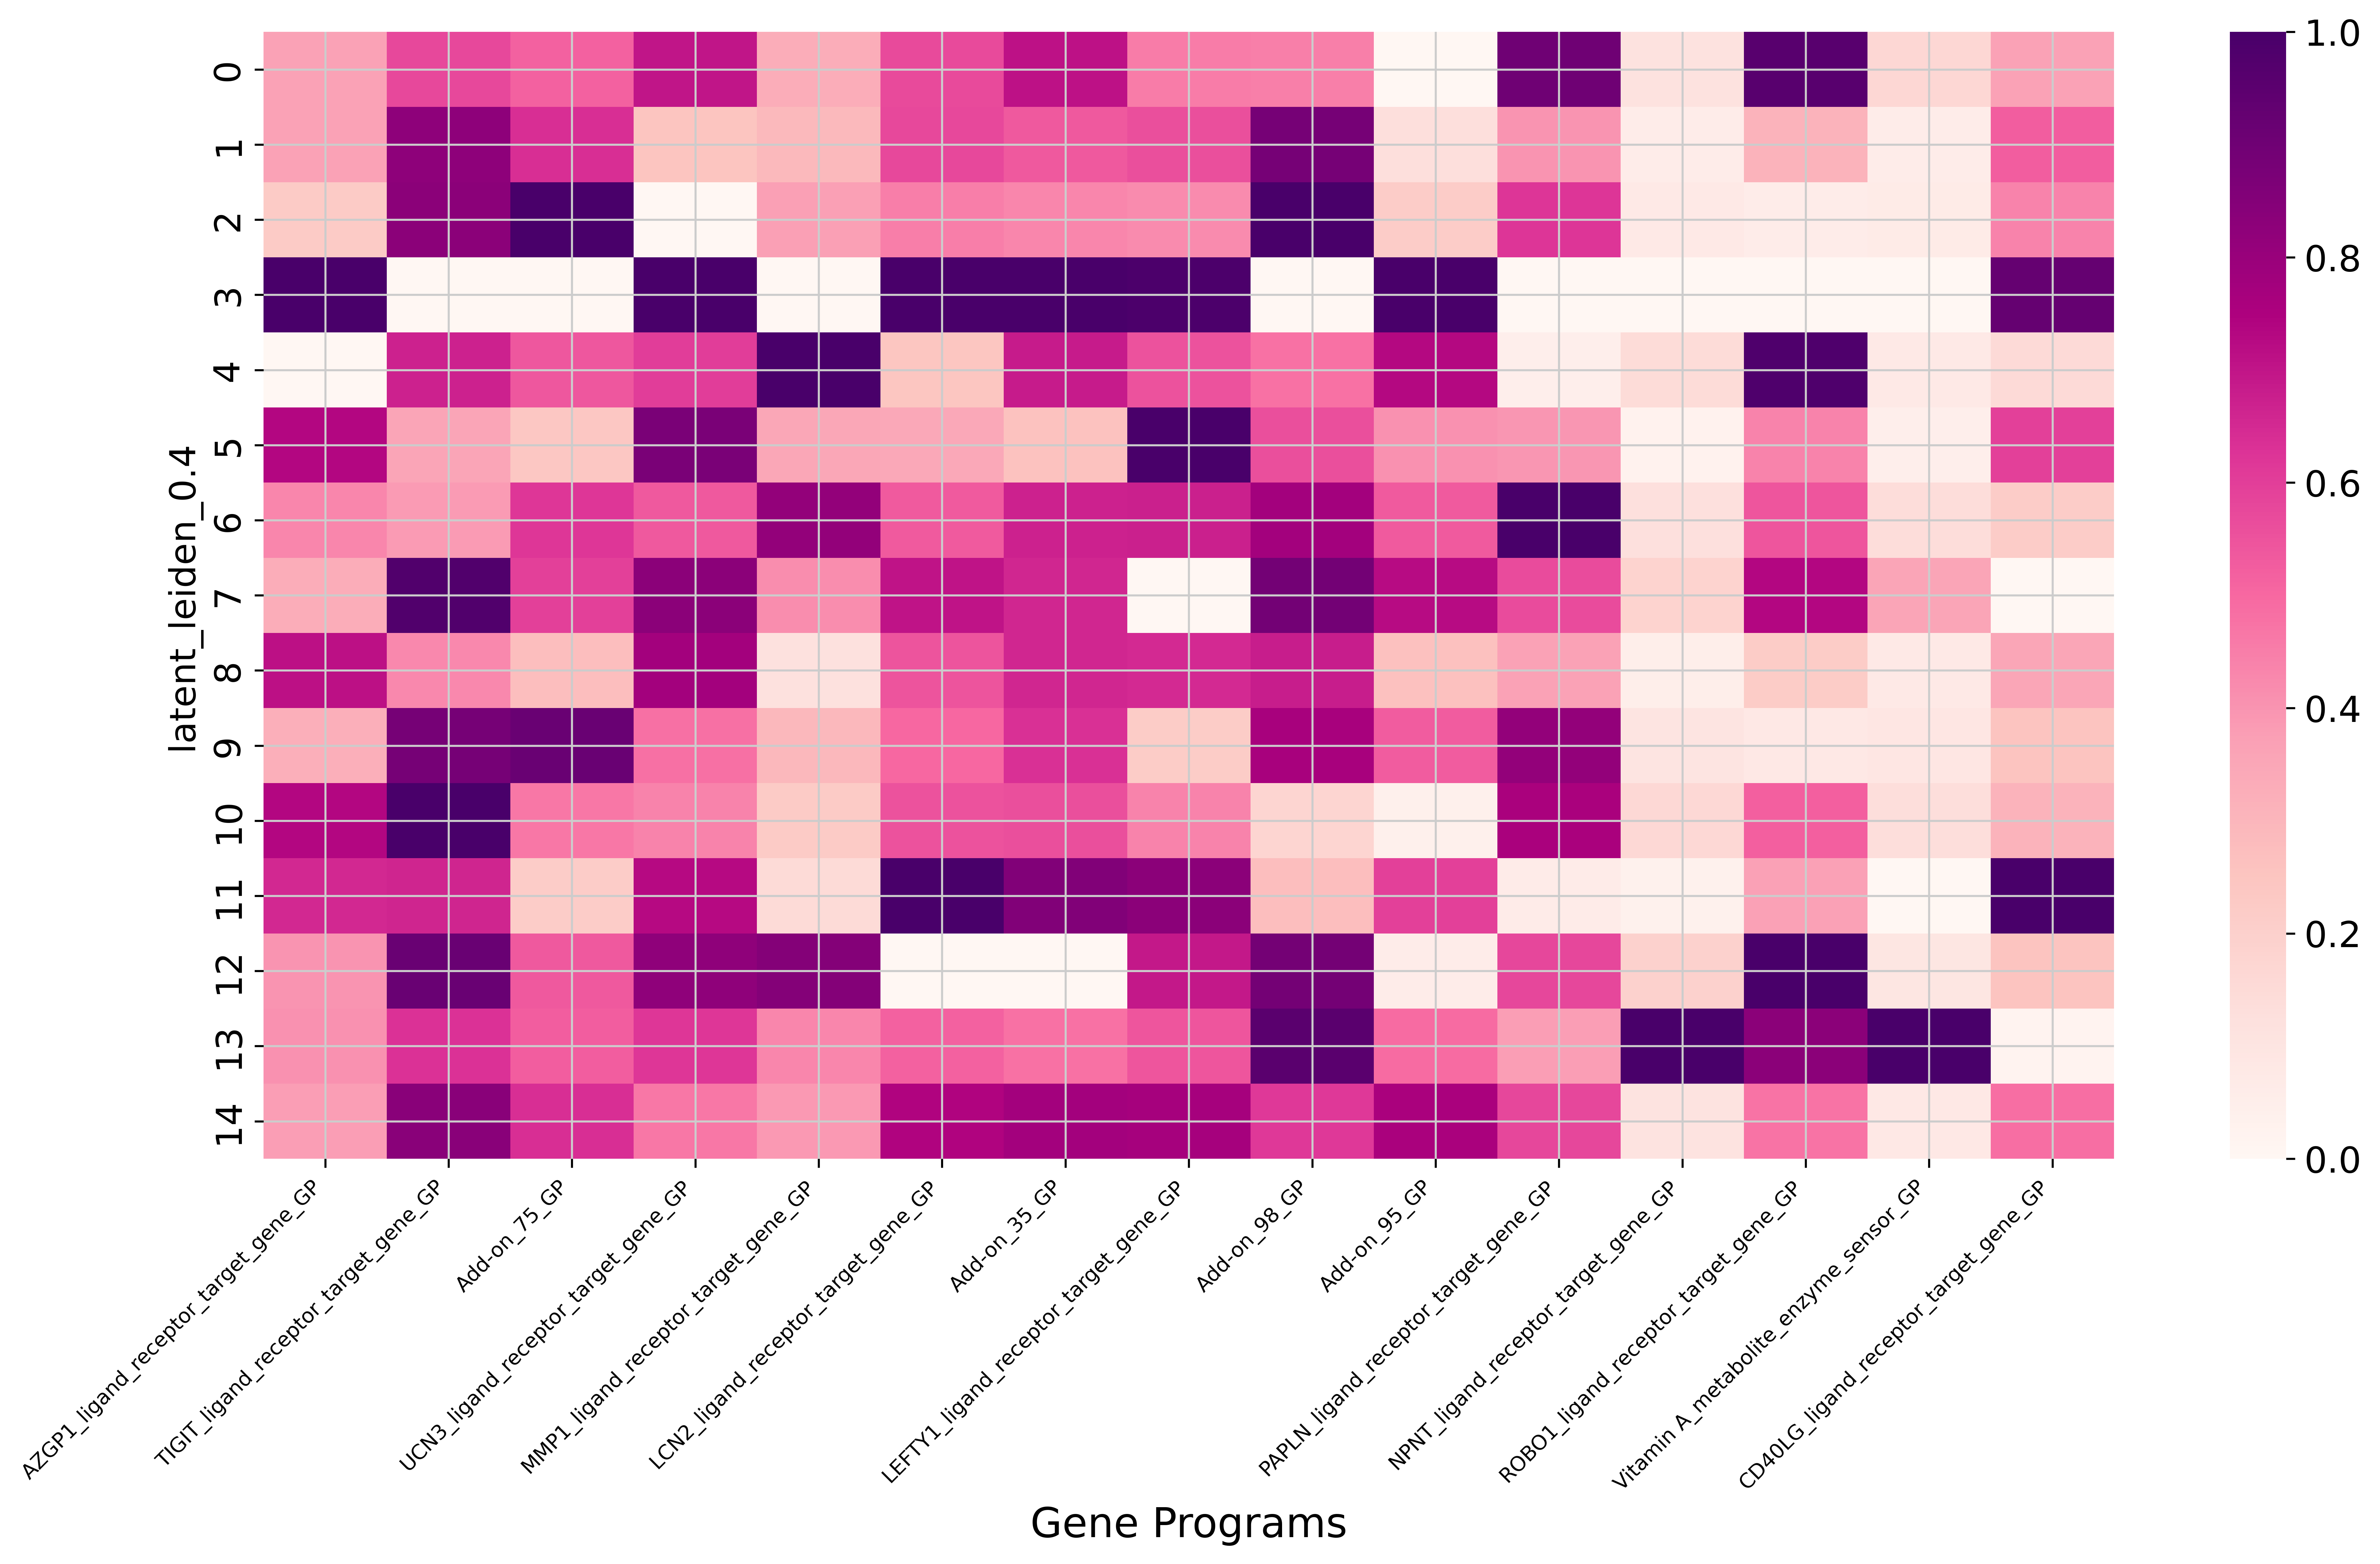

In [75]:
# Visualize GP activities of enriched GPs across niches
df = model.adata.obs[[latent_cluster_key] + enriched_gps].groupby(latent_cluster_key).mean()

scaler = MinMaxScaler()
normalized_columns = scaler.fit_transform(df)
normalized_df = pd.DataFrame(normalized_columns, columns=df.columns)
normalized_df.index = df.index

plt.figure(figsize=(16, 8))  # Set the figure size
ax = sns.heatmap(normalized_df,
            cmap='RdPu',
            annot=False,
            linewidths=0)
plt.xticks(rotation=45,
           fontsize=8,
           ha="right"
          )
plt.xlabel("Gene Programs", fontsize=16)
plt.savefig(f"{figure_folder_path}/enriched_gps_heatmap.png",
            bbox_inches="tight", dpi=300)

In [76]:
# Store gene program summary of enriched gene programs
save_file = True
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}_" \
            "niche_enriched_gps_summary.csv"

gp_summary_cols = ["gp_name",
                   "n_source_genes",
                   "n_non_zero_source_genes",
                   "n_target_genes",
                   "n_non_zero_target_genes",
                   "gp_source_genes",
                   "gp_target_genes",
                   "gp_source_genes_importances",
                   "gp_target_genes_importances"]

enriched_gp_summary_df = gp_summary_df[gp_summary_df["gp_name"].isin(enriched_gps)]
cat_dtype = pd.CategoricalDtype(categories=enriched_gps, ordered=True)
enriched_gp_summary_df.loc[:, "gp_name"] = enriched_gp_summary_df["gp_name"].astype(cat_dtype)
enriched_gp_summary_df = enriched_gp_summary_df.sort_values(by="gp_name")
enriched_gp_summary_df = enriched_gp_summary_df[gp_summary_cols]

if save_file:
    enriched_gp_summary_df.to_csv(f"{file_path}")
else:
    display(enriched_gp_summary_df)

In [77]:
adata_NC = model.adata.copy()

adata_NC

AnnData object with n_obs × n_vars = 274240 × 425
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'Cell_Type', 'Stem_cells', 'CellType2', 'Sample_id', 'latent_leiden_0.4', 'GZMB_ligand_receptor_target_gene_GP', 'RBP4_ligand_receptor_target_gene_GP', 'SLC6A8_ligand_receptor_target_gene_GP', 'Add-on_45_GP', 'Add-on_11_GP', 'CCL13_ligand_receptor_target_gene_GP', 'INSL5_ligand_receptor_target_gene_GP', 'RARRES2_ligand_receptor_target_gene_GP', 'Add-on_71_GP', 'Add-on_3_GP', 'Add-on_38_GP', 'TTR_ligand_receptor_target_gene_GP', 'Add-on_78_GP', 'LEFTY1_ligand_receptor_target_gene_GP', 'Add-on_18_GP', 'AZGP1_ligand_receptor_targe

In [78]:
adata_NC_log = adata_NC.copy()
sc.pp.normalize_total(adata_NC_log, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata_NC_log)

In [79]:
sc.set_figure_params(scanpy=True, dpi=300, figsize=(10, 10))
sq.pl.spatial_scatter(
    adata_NC_log, ncols = 5,
    library_id="spatial",
    img=True,
    img_res_key='lowres',
    shape=None,
    color=["AZGP1_ligand_receptor_target_gene_GP", 'AZGP1','CD36', 'ACTA2', 'CXCR4', 'EGFR', 'F3', 'TNFAIP3', 'HES1', 'IL1B'], cmap = 'RdPu',
    size=0.1,
    alpha=1
)

In [ ]:
sc.set_figure_params(scanpy=True, dpi=300, figsize=(10, 10))
sq.pl.spatial_scatter(
    adata_NC_log, ncols = 5,
    library_id="spatial",
    img=True,
    img_res_key='lowres',
    shape=None,
    color=["TIGIT_ligand_receptor_target_gene_GP", 'TIGIT','TNFAIP3', 'ID2', 'TYMS', 'RUNX1', 'EGFR', 'BMP4', 'IL1B', 'NUSAP1'], cmap = 'RdPu',
    size=0.1,
    alpha=1
)